<a href="https://colab.research.google.com/github/BehrozKhawar-23005633/MultiClass-Lung-Disease-Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import files
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K


# **Mount Google Drive**

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Verify dataset location**

In [119]:
!ls "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


# **Count Images in Each Class**
Let's verify the number of images in each category (COVID, Viral Pneumonia, Normal, Lung_Opacity) to check for imbalanced data.

In [120]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Count images in each category (inside 'images' subfolder)
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]
for category in categories:
    image_folder = os.path.join(dataset_path, category, "images")  # Access 'images' subfolder
    if os.path.exists(image_folder):  # Ensure the folder exists
        num_images = len(os.listdir(image_folder))
        print(f"Category: {category}, Image Count: {num_images}")
    else:
        print(f"Warning: No 'images' folder found in {category}")

Category: COVID, Image Count: 3616
Category: Viral Pneumonia, Image Count: 3600
Category: Normal, Image Count: 1345
Category: Lung_Opacity, Image Count: 6012


# **Visualizing Dataset Distribution Through Bar Plot**
Let's plot the class distribution to see the imbalance clearly.

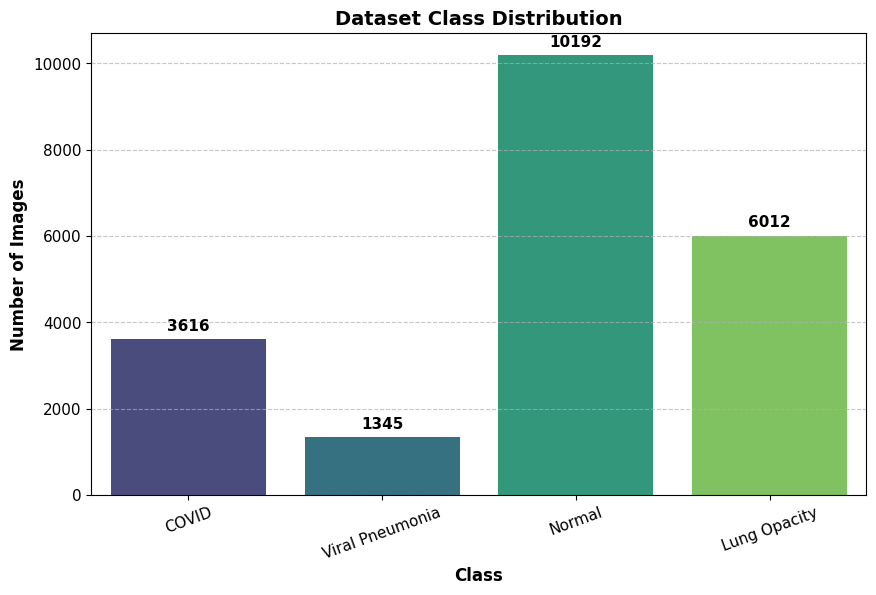

In [121]:
def plot_class_distribution(categories, image_counts, save_path="class_distribution.png"):
    """
    Plots and saves the dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Data
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung Opacity"]
image_counts = [3616, 1345, 10192, 6012]

# Generate and save plot
plot_class_distribution(categories, image_counts)

# **Data Balance Techniques**

1.   Under Sampling
2.   Over Sampling
3.   Data Augmentation



**1. Under Sampling**

* Reduces the number of images in a Normal images  by randomly selecting a subset to match with Viral Pneumonia images count


In [122]:
def undersample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)

    if len(all_images) > target_count:
        # Randomly select images to keep
        selected_images = random.sample(all_images, target_count)

        # Move unselected images to a backup folder
        backup_folder = os.path.join(class_path, "backup_images")
        os.makedirs(backup_folder, exist_ok=True)

        for img in all_images:
            if img not in selected_images:
                shutil.move(os.path.join(images_folder, img), os.path.join(backup_folder, img))

        print(f"Undersampling Complete: Retained {target_count} images in {class_path}")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply undersampling to Normal class
undersample_class(os.path.join(dataset_path, "Normal"), target_count=1345)


**Undersampling Bar Plot**

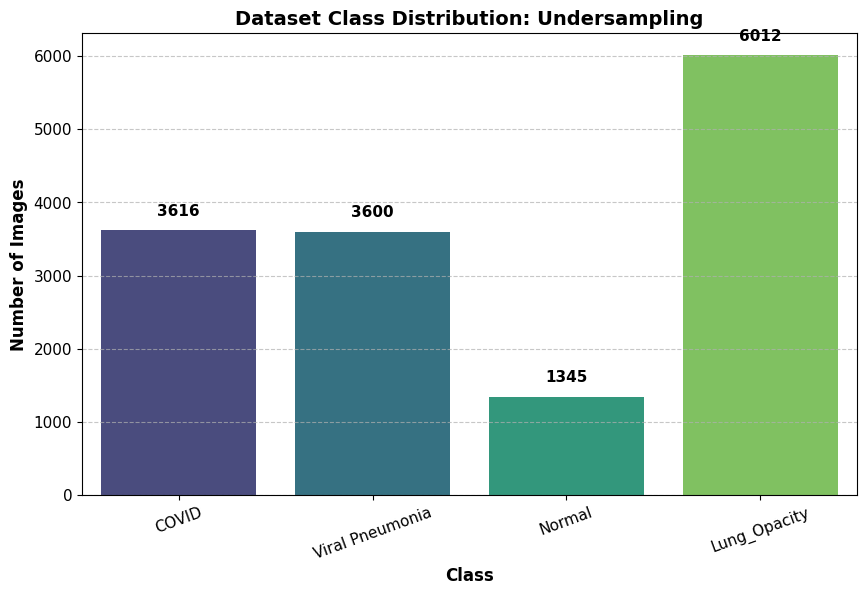

In [123]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after undersampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution: Undersampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

**2. OverSampling**

* Increases the number of images in Viral Penumenia class by duplicating existing images to match Closet Class i-e Covid Samples Images





In [124]:
def oversample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)
    current_count = len(all_images)

    if current_count < target_count:
        num_to_add = target_count - current_count
        print(f"Oversampling: Need to add {num_to_add} images to {class_path}")

        for i in range(num_to_add):
            img_to_copy = random.choice(all_images)  # Randomly pick an image
            new_img_name = f"copy_{i}_{img_to_copy}"  # Rename the duplicate
            shutil.copy(os.path.join(images_folder, img_to_copy),
                        os.path.join(images_folder, new_img_name))

        print(f"Oversampling Complete: {target_count} images now in {class_path}")
    else:
        print(f"Oversampling Not Needed: {class_path} already has sufficient images")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply oversampling to Viral Pneumonia class (match COVID count of ~3,600)
oversample_class(os.path.join(dataset_path, "Viral Pneumonia"), target_count=3600)


Oversampling Not Needed: /content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia already has sufficient images


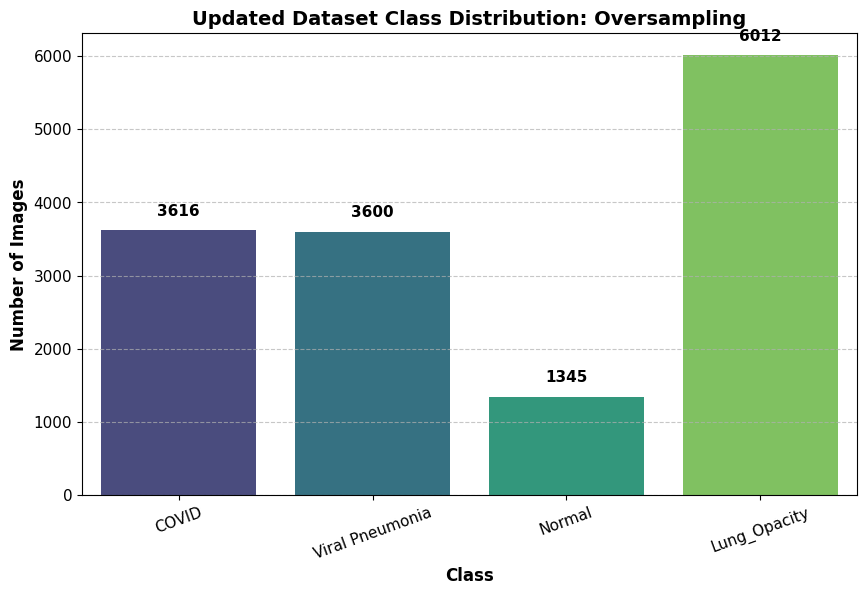

In [125]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after oversampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Updated Dataset Class Distribution: Oversampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

## **Data Augmentation**

*   We will test augmentation techniques here and decide which are gonna be use in our learning models



**Step 1: Rotation Augmentation**

*    Applies random rotation to an image.



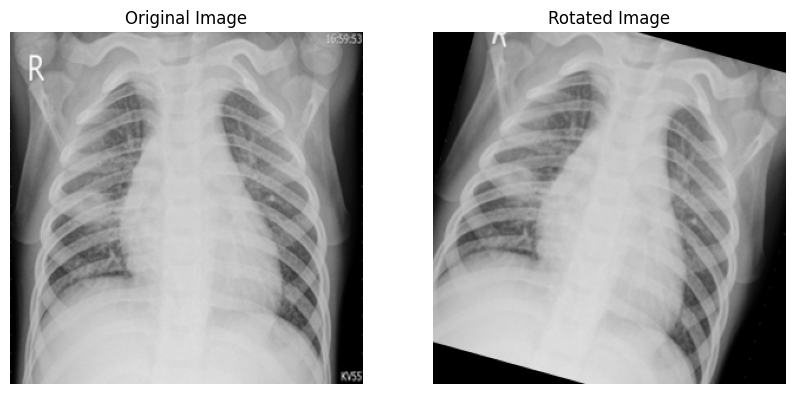

In [126]:
def apply_rotation(image_path, rotation_range=30):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]

    # Choose a random rotation angle
    angle = random.uniform(-rotation_range, rotation_range)

    # Compute rotation matrix
    M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (width, height))

    return rotated_image

# Select a random image from the dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
sample_image_path = os.path.join(image_folder, sample_image)

# Apply Rotation
rotated_image = apply_rotation(sample_image_path)

# Plot Original vs Rotated Image
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rotated_image)
plt.title("Rotated Image")
plt.axis("off")

plt.savefig("rotation_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step 2: Flipping Augmentation (Horizontal + Vertical)**

*   Applies both horizontal and vertical flip to an image.



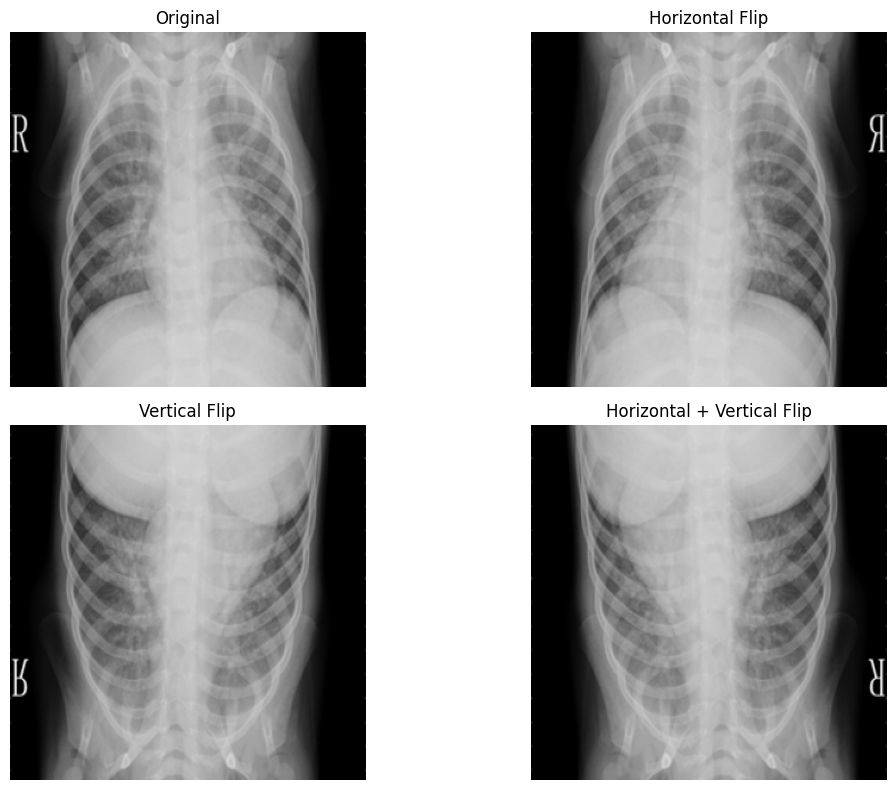

In [127]:
def apply_flipping(image_path):

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply flipping
    flip_h = cv2.flip(image, 1)   # Horizontal
    flip_v = cv2.flip(image, 0)   # Vertical
    flip_both = cv2.flip(image, -1)  # Both

    return image, flip_h, flip_v, flip_both

# Select a sample image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply flipping
original, h_flip, v_flip, both_flip = apply_flipping(image_path)

# Plot the results
titles = ["Original", "Horizontal Flip", "Vertical Flip", "Horizontal + Vertical Flip"]
images = [original, h_flip, v_flip, both_flip]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("flipping_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-3 Contrast Adjustment**

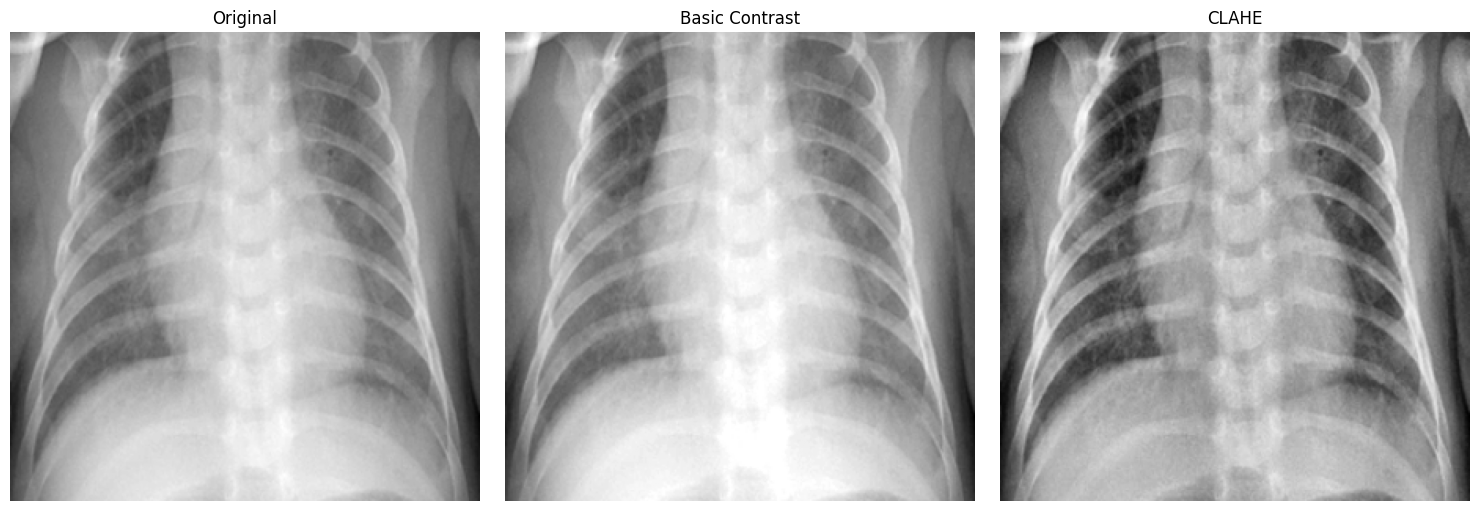

In [128]:
def contrast_adjustments(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Basic contrast scaling
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    basic_contrast_img = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(image)

    return image, basic_contrast_img, clahe_img

# Pick a random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply contrast methods
original, contrast_scaled, clahe_result = contrast_adjustments(image_path)

# Plot
titles = ["Original", "Basic Contrast", "CLAHE"]
images = [original, contrast_scaled, clahe_result]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("contrast_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-4 Zooming & Cropping Augmentation**


*  Creates synthetic examples where the chest X-ray is zoomed in slightly and cropped.



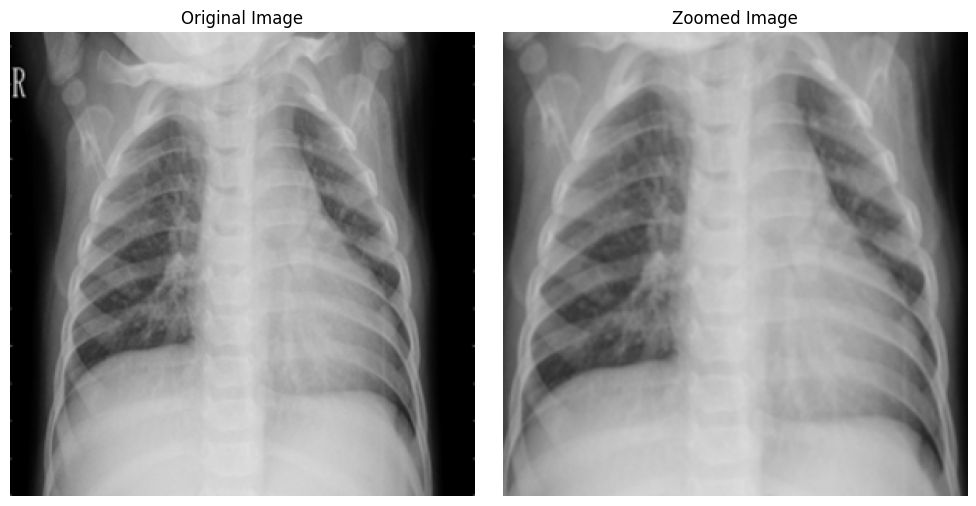

In [129]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def apply_zoom_crop(image_path, zoom_factor=1.2):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Calculate cropping boundaries
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - new_h) // 2, (w - new_w) // 2
    cropped_img = image[start_h:start_h+new_h, start_w:start_w+new_w]

    # Resize back to original size
    zoomed_img = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)

    return image, zoomed_img

# Random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply zoom
original, zoomed = apply_zoom_crop(image_path)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(zoomed)
plt.title("Zoomed Image")
plt.axis("off")

plt.tight_layout()
plt.savefig("zoomed_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step-5 Noise & Blur Augmentation**

*       Applies Gaussian blur and noise to an image.



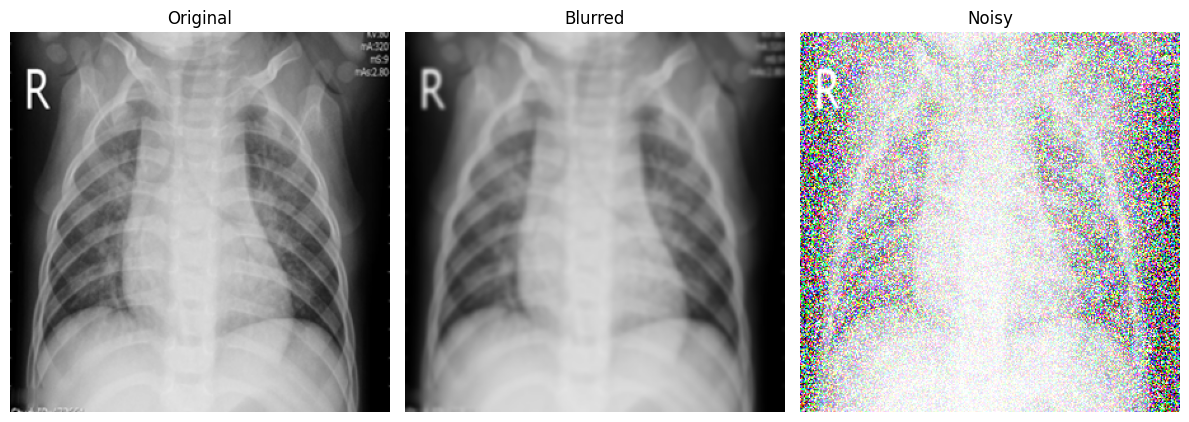

In [130]:
def apply_noise_blur(image_path):
    """
    Applies Gaussian blur and noise to an image.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(image, (7, 7), 0)

    # Add Gaussian Noise
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy = cv2.add(image, noise)

    return image, blurred, noisy

# Pick a random image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply augmentations
original, blurred_img, noisy_img = apply_noise_blur(image_path)

# Plot results
titles = ["Original", "Blurred", "Noisy"]
images = [original, blurred_img, noisy_img]

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("noise_blur_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


**Final Augmentation Function**

*   Below is a clean, reusable data augmentation function that combines all the approved augmentation techniques



In [131]:
def apply_augmentations_with_label(image):
    applied = []

    # --- Rotation ---
    angle = random.uniform(-15, 15)
    applied.append(f"Rotated({angle:.1f}°)")
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # --- Horizontal Flip ---
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        applied.append("Flipped")

    # --- CLAHE Contrast ---
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(gray)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    applied.append("CLAHE")

    # --- Zoom + Crop ---
    zoom_factor = 1.2
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - zh) // 2, (w - zw) // 2
    image = image[start_h:start_h+zh, start_w:start_w+zw]
    image = cv2.resize(image, (w, h))
    applied.append("Zoom")

    # --- Gaussian Blur (Optional) ---
    if random.random() > 0.7:
        image = cv2.GaussianBlur(image, (5, 5), 0)
        applied.append("Blur")

    return image, " + ".join(applied)


**Apply Augmentation Function to a Batch & Visualize Samples**

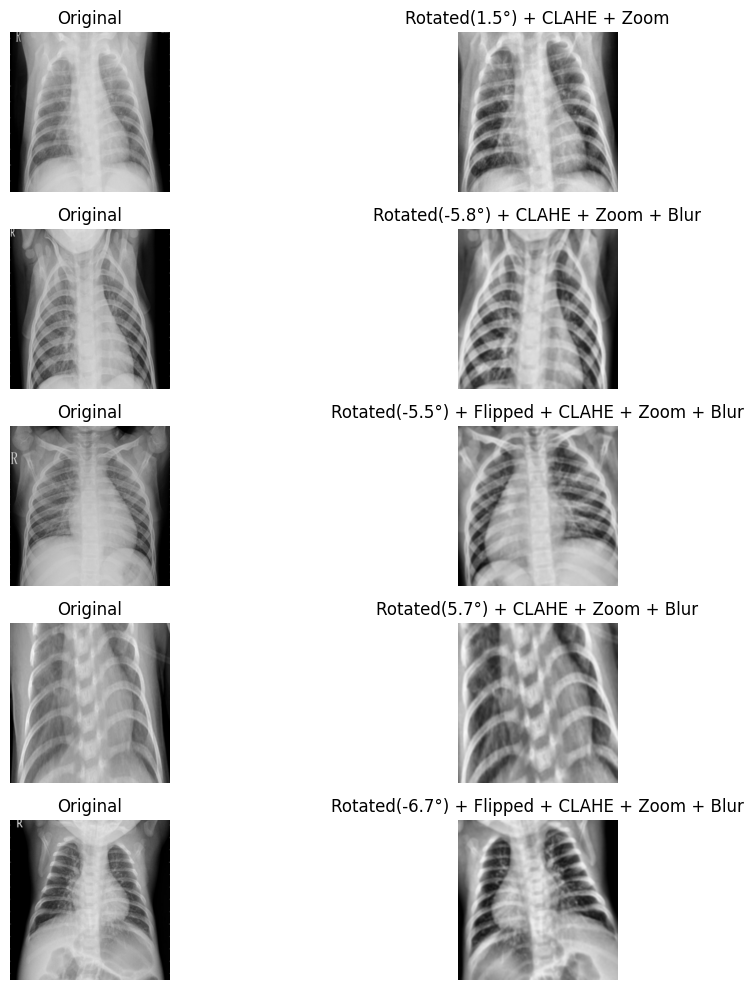

In [132]:
def load_images_from_folder(folder_path, count=5):
    """
    Loads a small batch of RGB images from a folder.
    """
    image_files = random.sample(os.listdir(folder_path), count)
    images = []
    for file in image_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((file, img))
    return images

def visualize_augmented_batch_with_labels(folder_path, sample_size=5):
    batch = load_images_from_folder(folder_path, count=sample_size)

    plt.figure(figsize=(12, 2 * sample_size))
    for i, (filename, img) in enumerate(batch):
        aug_img, label = apply_augmentations_with_label(img)

        # Original
        plt.subplot(sample_size, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        # Augmented with applied label
        plt.subplot(sample_size, 2, 2 * i + 2)
        plt.imshow(aug_img)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("labeled_augmented_batch.png", dpi=300, bbox_inches="tight")
    plt.show()


category_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

# Run the visualizer
visualize_augmented_batch_with_labels(category_path, sample_size=5)


## **Augmented images Pipeline**

*   Generate and save augmented images for the underrepresented classes so we can match them to ~10,000 samples each.



In [133]:
def augment_and_save_images(input_dir, output_dir, target_count, augment_fn):
    """
    Generates and saves augmented images until target_count is reached.

    Parameters:
    - input_dir: folder with original images
    - output_dir: where augmented images will be saved
    - target_count: desired total number of images (original + augmented)
    - augment_fn: function to apply augmentations
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))]
    current_count = len(os.listdir(output_dir))
    print(f"Original image count: {current_count}")

    if current_count >= target_count:
        print("No augmentation needed. Already at or above target.")
        return

    num_to_generate = target_count - current_count
    print(f"Generating {num_to_generate} augmented images...")

    i = 0
    while i < num_to_generate:
        img_name = random.choice(image_files)
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply your custom augmentation pipeline
        aug_img = augment_fn(img)

        save_path = os.path.join(output_dir, f"aug_{i}_{img_name}")
        cv2.imwrite(save_path, aug_img)
        i += 1

    print(f"✅ Augmentation complete. Total saved: {num_to_generate} images.")

**Augmented Viral Penumonia Images**

In [134]:
import os

def custom_augment_pipeline(img):
    # Rotate + CLAHE + Zoom (as tested)
    angle = random.uniform(-12, 12)
    h, w = img.shape[:2]

    # Rotation
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Zoom
    zoom_factor = 1.1
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    top = (h - zh) // 2
    left = (w - zw) // 2
    img = img[top:top+zh, left:left+zw]
    img = cv2.resize(img, (w, h))

    return img

# === Configuration ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia'.


**Augmented Covid Images**

In [135]:
# === Configuration for COVID ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/COVID"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/COVID'.


**Augmented Lung Opacity Images**

In [136]:
# === Configuration for Lung Opacity ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Lung_Opacity"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Lung_Opacity'.


# **Count & Plot Final Class Distribution**

COVID: 2500 images
Viral Pneumonia: 2500 images
Lung_Opacity: 2500 images


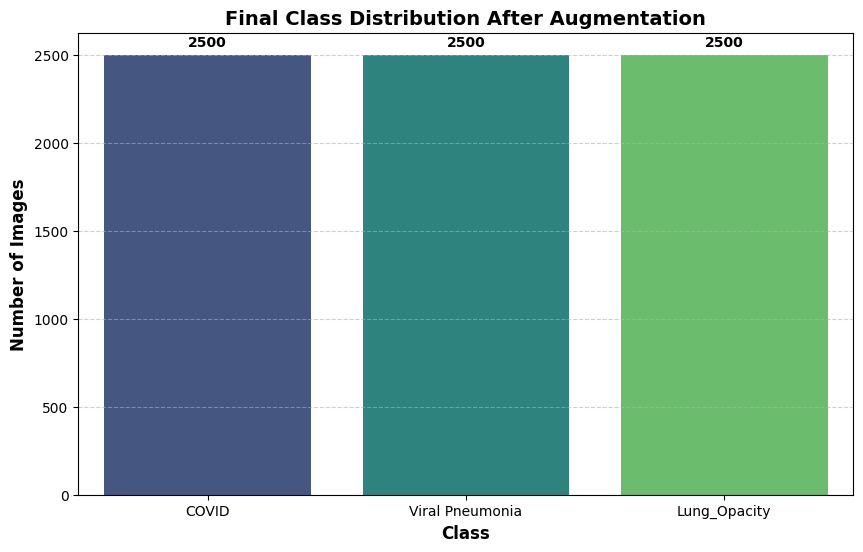

In [137]:
# Path to augmented dataset
augmented_path = "/content/drive/MyDrive/Colab Notebooks/Augmented"
categories = ["COVID", "Viral Pneumonia", "Lung_Opacity"]

# Count images in each folder
image_counts = {}
for category in categories:
    class_path = os.path.join(augmented_path, category)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))])
    image_counts[category] = count
    print(f"{category}: {count} images")

# Plotting
def plot_augmented_distribution(counts_dict, save_path="augmented_distribution_plot.png"):
    categories = list(counts_dict.keys())
    counts = list(counts_dict.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=counts, hue=categories, palette="viridis", legend=False)

    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', fontweight='bold')

    plt.title("Final Class Distribution After Augmentation", fontsize=14, fontweight='bold')
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Call the function to plot
plot_augmented_distribution(image_counts)


**Move Normal Images to Augmented Folder**

In [138]:
import os
import random
import shutil

def copy_normal_images(source_dir, dest_dir, num_images=2500):
    """
    Copies a random subset of Normal images to the Augmented folder without augmentation.
    Skips copying if images already exist.
    """
    # Check if already exists
    if os.path.exists(dest_dir) and len(os.listdir(dest_dir)) >= num_images:
        print(f"✅ Skipping copy. {len(os.listdir(dest_dir))} images already exist in '{dest_dir}'.")
        return

    os.makedirs(dest_dir, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Total images in Normal folder: {len(image_files)}")

    # Randomly select images
    selected = random.sample(image_files, min(num_images, len(image_files)))

    # Copy images
    for i, img_name in enumerate(selected):
        src_path = os.path.join(source_dir, img_name)
        dest_path = os.path.join(dest_dir, f"normal_{i}_{img_name}")
        shutil.copyfile(src_path, dest_path)

    print(f"✅ Copied {len(selected)} images to '{dest_dir}'.")

# === Paths ===
normal_input = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Normal/images"
normal_output = "/content/drive/MyDrive/Colab Notebooks/Augmented/Normal"

# === Run the copy ===
copy_normal_images(normal_input, normal_output, num_images=2500)


✅ Skipping copy. 2689 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Normal'.


# **Final Train/Val/Test Split Script (Dynamic)**

*   Splits each class folder in source_dir into train/val/test folders under dest_base_dir.
    Automatically skips if already done.



In [139]:
def split_dataset(source_dir, dest_base_dir, split_ratios=(0.7, 0.2, 0.1), seed=42):
    import os, random, shutil

    random.seed(seed)
    class_names = os.listdir(source_dir)

    # Check if already split
    train_path = os.path.join(dest_base_dir, "train")
    if os.path.exists(train_path) and all(
        os.path.exists(os.path.join(train_path, cls)) and len(os.listdir(os.path.join(train_path, cls))) > 0
        for cls in class_names
    ):
        print("✅ Split already exists. Skipping.")
        return

    # Proceed with splitting
    for class_name in class_names:
        class_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))]
        random.shuffle(images)

        total = len(images)
        train_count = int(total * split_ratios[0])
        val_count = int(total * split_ratios[1])
        test_count = total - train_count - val_count

        splits = {
            "train": images[:train_count],
            "val": images[train_count:train_count + val_count],
            "test": images[train_count + val_count:]
        }

        for split_type, split_images in splits.items():
            split_dir = os.path.join(dest_base_dir, split_type, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copyfile(src_path, dst_path)

        print(f"✅ {class_name}: {train_count} train, {val_count} val, {test_count} test")

# === Paths ===
source_path = "/content/drive/MyDrive/Colab Notebooks/Augmented"
destination_path = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"

# === Run the split (delete Final_Dataset/val before running) ===
split_dataset(source_path, destination_path)


✅ Split already exists. Skipping.


# **Build Image Pipelines**

**Step 1 - Use Tenserflow Built-In Pipepline Loader**

*  This is TensorFlow’s built-in pipeline loader — fast, clean, and supports batching and shuffling automatically.





In [140]:
# === Dataset paths ===
base_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"
batch_size = 32
img_size = (224, 224)  # You can adjust if needed

# === Load datasets ===
train_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "test"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)


Found 7132 files belonging to 4 classes.
Found 2037 files belonging to 4 classes.
Found 1020 files belonging to 4 classes.


**Step-2 Add Light Augmentation to Training Pipeline Only**

In [141]:
from tensorflow.keras import layers

# Light augmentations for training only
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


**Step-3 Normalize & Apply Augmentation**

In [142]:
# Apply augmentation and normalization to train set only
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

# Just normalize val/test (no augmentation!)
val_ds = (
    val_ds
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (
    test_ds
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

raw_train_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

# ✅ Extract class names before mapping/augmentation
class_names = raw_train_ds.class_names


Found 7132 files belonging to 4 classes.


**Preview One Batch of Training Images**

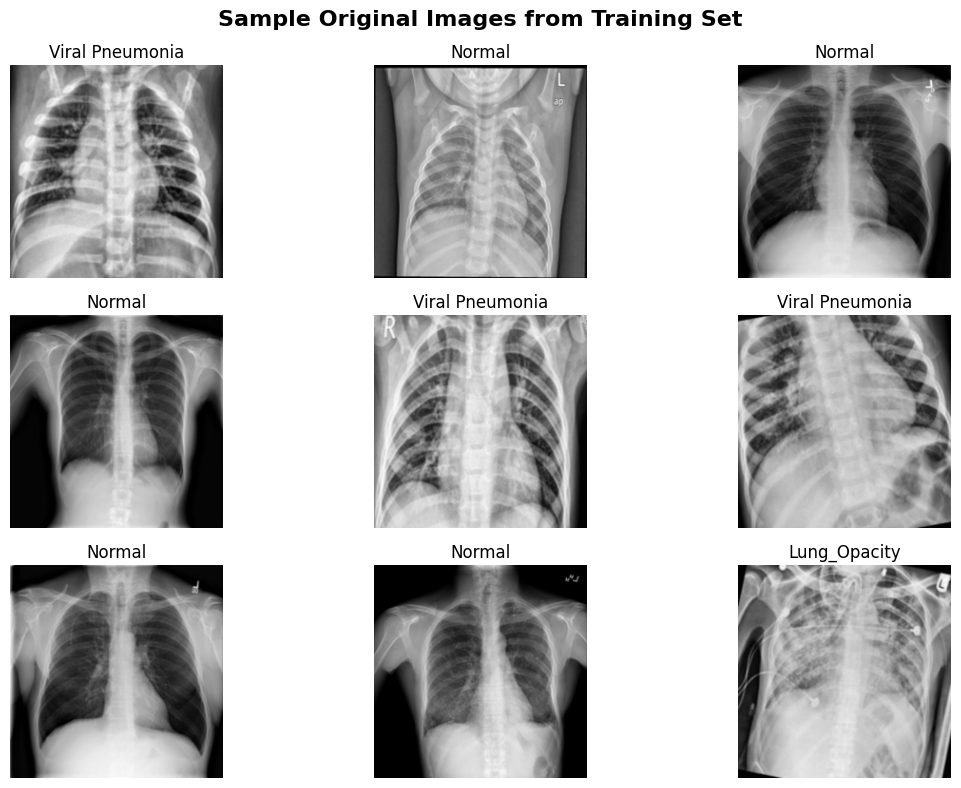

In [143]:
# Grab one batch from the training set

for images, labels in raw_train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.suptitle("Sample Original Images from Training Set", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# **Custom Deeper CNN Model Implementation**

**Model Summary**

In [144]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),  # ✅ Explicit Input layer

        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 4
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Classifier head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and view summary
model = build_custom_cnn()
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,588 (25.98 MB)

 Trainable params: 6,811,588 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

**Compile and Train the Model**

Loss: categorical_crossentropy (you’re using one-hot labels).

Optimizer: Adam (good default choice).

Metrics: accuracy for performance tracking.



In [145]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Low LR for stable training
    metrics=['accuracy']
)


**Add Training Callbacks**


*   ✅ EarlyStopping:
Stops training when validation loss stops improving (prevents overfitting).

*   ✅ ModelCheckpoint:
Saves the best weights (based on validation accuracy).



In [146]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_custom_cnn_model.keras", save_best_only=True)
]


In [147]:
import os
import math

# === Count total images in train and val directories ===
train_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset/val"

def count_images_in_directory(directory):
    total = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)

# === Set steps based on batch size ===
batch_size = 32
steps_per_epoch = math.ceil(train_count / batch_size)
validation_steps = math.ceil(val_count / batch_size)

print(f"✅ Total train images: {train_count}, steps/epoch: {steps_per_epoch}")
print(f"✅ Total val images: {val_count}, val steps: {validation_steps}")


✅ Total train images: 7132, steps/epoch: 223
✅ Total val images: 2037, val steps: 64


In [148]:
# Define steps
train_steps = 255  # Based on your total train images / batch size
val_steps = 32     # Based on val images / batch size

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)


Epoch 1/30
222/255 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4576 - loss: 1.1760

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 98s 52ms/step - accuracy: 0.4728 - loss: 1.1477 - val_accuracy: 0.6484 - val_loss: 0.7426
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7312 - loss: 0.6188 - val_accuracy: 0.6797 - val_loss: 0.7508
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7809 - loss: 0.5135 - val_accuracy: 0.6787 - val_loss: 0.6892
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7896 - loss: 0.4876 - val_accuracy: 0.6709 - val_loss: 0.7898
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8066 - loss: 0.4560 - val_accuracy: 0.7354 - val_loss: 0.6267
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8316 - loss: 0.4067 - val_accuracy: 0.7129 - val_loss: 0.6817
Epoch 7/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8538 - loss: 0.3527 - val_accuracy: 0.7471 - val_loss: 0.5773
Epoch 8/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8571 - loss: 0.3307 - val_accurac

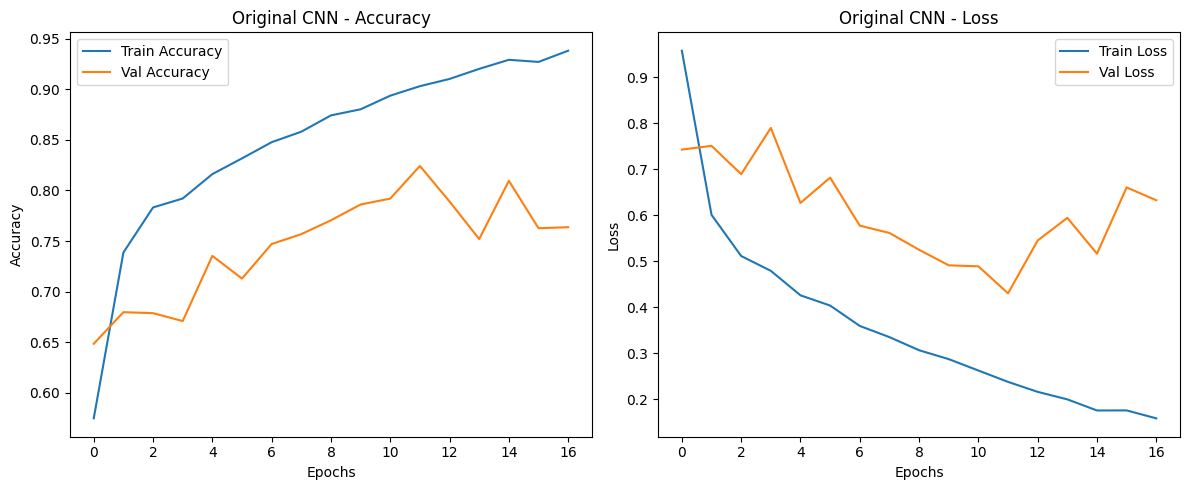

In [149]:
def plot_training_history(history, model_name="Custom CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, model_name="Original CNN")

# **CCN Model Improvments**



*   Add Batch Normalization to Improve Learning Stability
*   Use EarlyStopping & ModelCheckpoint in Keras
*   Use EarlyStopping & ModelCheckpoint in Keras format








In [150]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

def build_improved_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model

# Complie the model
model = build_improved_cnn()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add Training Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_improved_cnn_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Train the Model
epochs = 30
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)



Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.6218 - loss: 1.3654 - val_accuracy: 0.3937 - val_loss: 2.5137 - learning_rate: 1.0000e-04
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8302 - loss: 0.4105 - val_accuracy: 0.7339 - val_loss: 0.6526 - learning_rate: 1.0000e-04
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8756 - loss: 0.3006 - val_accuracy: 0.8729 - val_loss: 0.3159 - learning_rate: 1.0000e-04
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9027 - loss: 0.2418 - val_accuracy: 0.9092 - val_loss: 0.2524 - learning_rate: 1.0000e-04
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9312 - loss: 0.1775 - val_accuracy: 0.8817 - val_loss: 0.3290 - learning_rate: 1.0000e-04
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9396 - loss: 0.1555 - val_accuracy: 0.9200 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/ste

**Plot The Training Results**

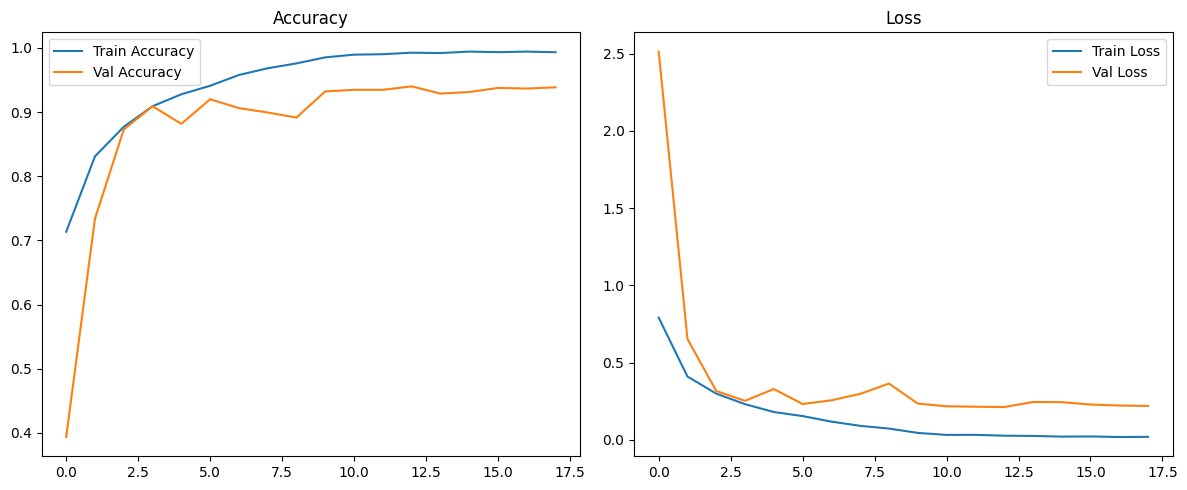

In [151]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history)


# **Visualising CNN Model Test Predictions**

**1-Load the best saved model**

In [152]:
# Load best improved model
model = load_model("best_improved_cnn_model.keras")


**2. Make Predictions on Test Set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


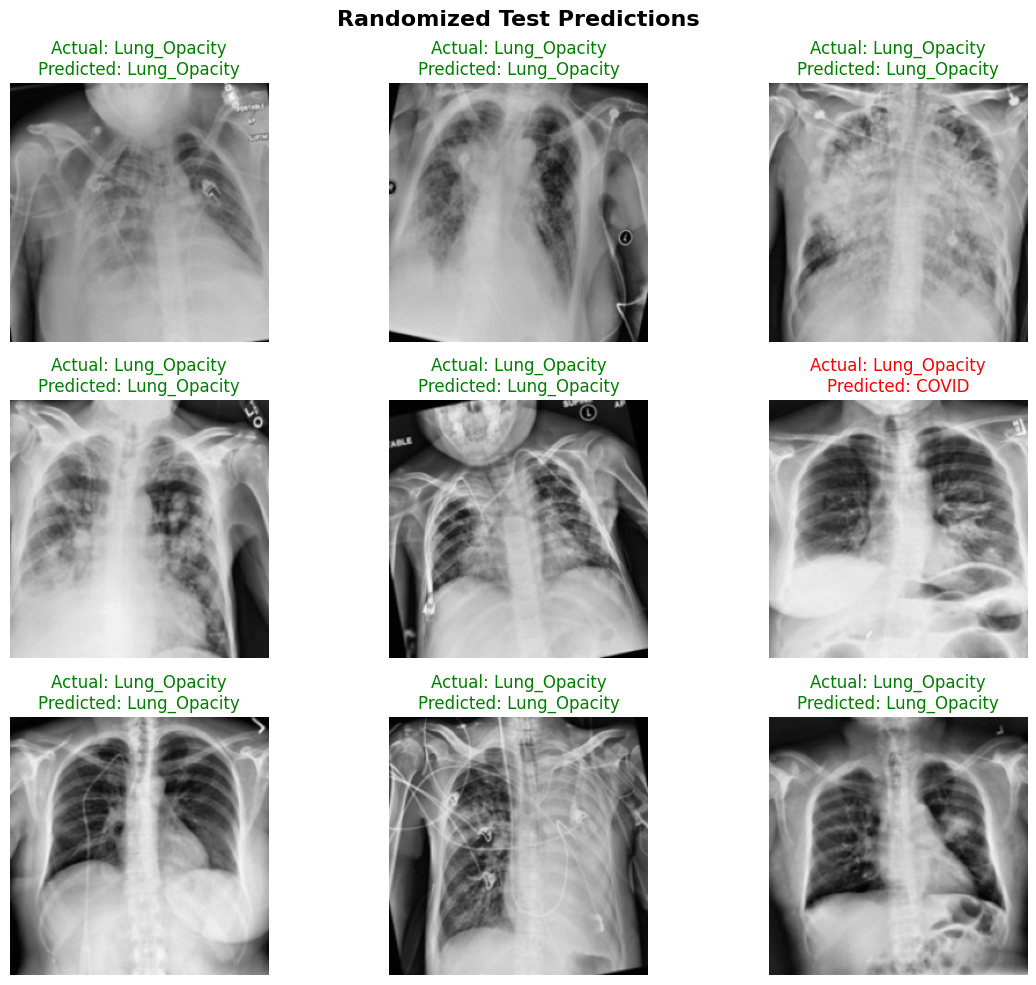

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle test set and take one batch randomly
shuffled_test = test_ds.shuffle(1000, seed=np.random.randint(1, 10000))

# Set number of samples
num_samples = 9
plt.figure(figsize=(12, 10))

for images, labels in shuffled_test.take(1):
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels.numpy(), axis=1)

    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze()
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.axis("off")

        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=color)

plt.suptitle("Randomized Test Predictions", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


**3- Classification Report**

In [154]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Flatten predictions and labels
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Get class names (from raw_train_ds earlier)
class_labels = class_names  # e.g., ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

# Generate the report as a dictionary
report_dict = classification_report(
    y_true, y_pred, target_names=class_labels, output_dict=True, zero_division=0
)

# Convert to pandas DataFrame for nice display
report_df = pd.DataFrame(report_dict).transpose()

# Display the key metrics only
print(report_df[["precision", "recall", "f1-score", "support"]].round(3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

**4-Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

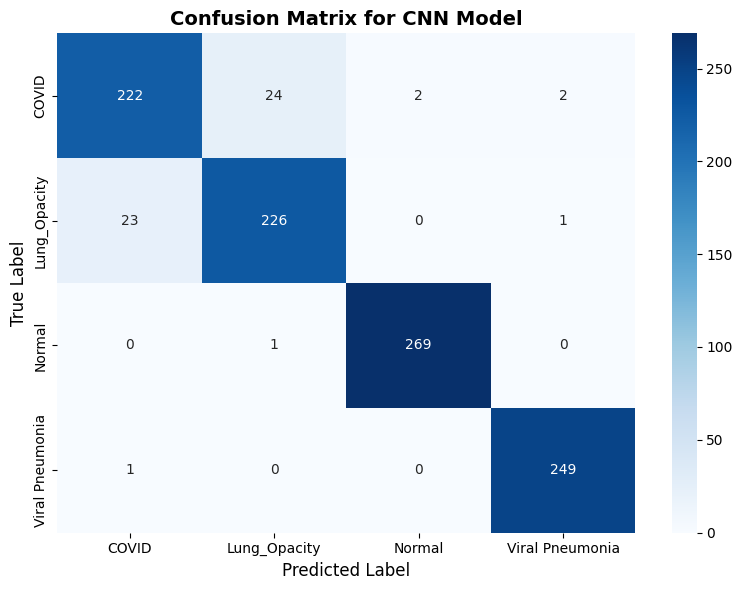

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Reuse y_true and y_pred from your earlier classification report block
# If not available, regenerate them:
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Get class labels
class_labels = class_names  # e.g., ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix for CNN Model", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# **RES-NET 50 Model**

# **Initial REST-NET50 Model**

In [225]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load ResNet50 with Imagenet weights
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Unfreeze last 30 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Build custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile with smaller LR for fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("initial_resnet50_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

#Train
epochs = 15
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11829']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


223/223 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.5892 - loss: 0.9564 - val_accuracy: 0.6598 - val_loss: 1.1192 - learning_rate: 1.0000e-05
Epoch 2/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.8016 - loss: 0.5073 - val_accuracy: 0.8046 - val_loss: 0.4900 - learning_rate: 1.0000e-05
Epoch 3/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.8445 - loss: 0.4006 - val_accuracy: 0.8272 - val_loss: 0.4328 - learning_rate: 1.0000e-05
Epoch 4/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8581 - loss: 0.3630 - val_accuracy: 0.8159 - val_loss: 0.4169 - learning_rate: 1.0000e-05
Epoch 5/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8844 - loss: 0.3058 - val_accuracy: 0.6470 - val_loss: 1.3916 - learning_rate: 1.0000e-05
Epoch 6/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8821 - loss: 0.2994
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0

                 precision    recall  f1-score   support

          COVID       0.80      0.86      0.83       250
   Lung_Opacity       0.88      0.80      0.84       250
         Normal       0.97      0.96      0.96       270
Viral Pneumonia       0.96      0.98      0.97       250

       accuracy                           0.90      1020
      macro avg       0.90      0.90      0.90      1020
   weighted avg       0.90      0.90      0.90      1020



<ipython-input-226-301bba246470>:31: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-226-301bba246470>:32: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig("resnet_classification_report.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


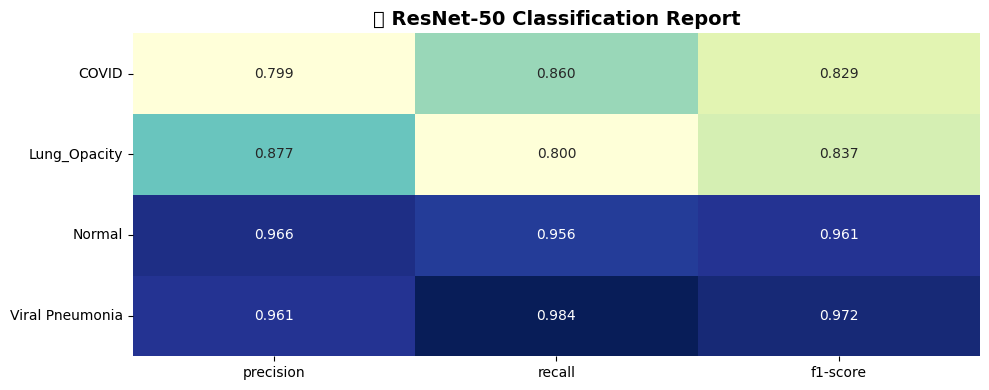

In [226]:
# ✅ Use the same model used for evaluation
model = load_model("initial_resnet50_model.keras")

# ✅ Ensure dataset has no shuffling or batching
test_ds_unbatched = test_ds.unbatch()
y_true = []
y_pred = []

for img, label in test_ds_unbatched:
    y_true.append(np.argmax(label.numpy()))
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    y_pred.append(np.argmax(pred))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Use consistent class names
class_names = temp_test_ds.class_names

# ✅ Classification report (Text)
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Classification report (Heatmap)
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

plt.figure(figsize=(10, 4))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title("📋 ResNet-50 Classification Report", fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("resnet_classification_report.png", dpi=300)
plt.show()

**Confusion Matrix**

<ipython-input-227-71e6f10f46b8>:10: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-227-71e6f10f46b8>:11: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig("resnet_confusion_matrix.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


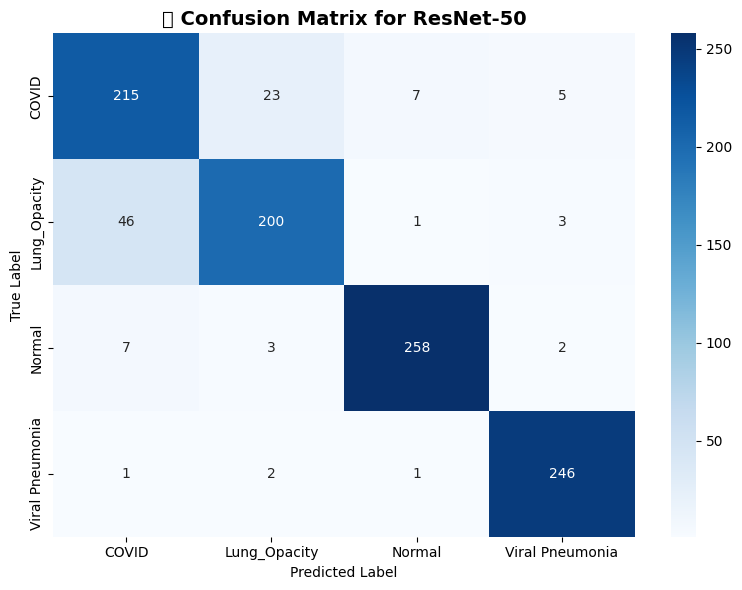

In [227]:
# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("🧩 Confusion Matrix for ResNet-50", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("resnet_confusion_matrix.png", dpi=300)
plt.show()

**Plotting ResNet-50 Training History**

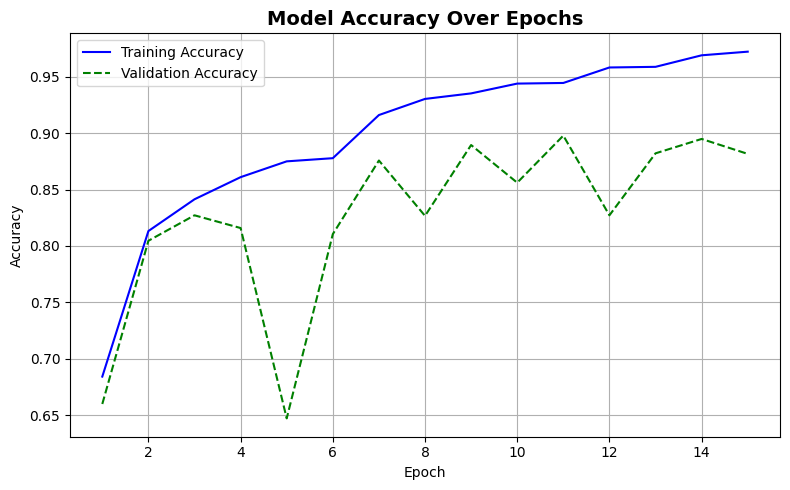

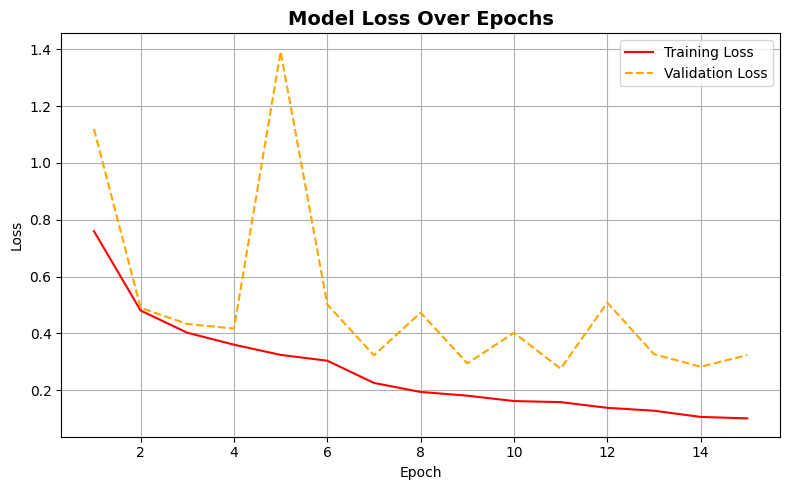

In [229]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # 📈 Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_plot.png", dpi=300)
    plt.show()

    # 📉 Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', linestyle='--', label='Validation Loss')
    plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png", dpi=300)
    plt.show()

# ✅ Call the function
plot_training_curves(history)


**5- Make Predictions on Test Set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━

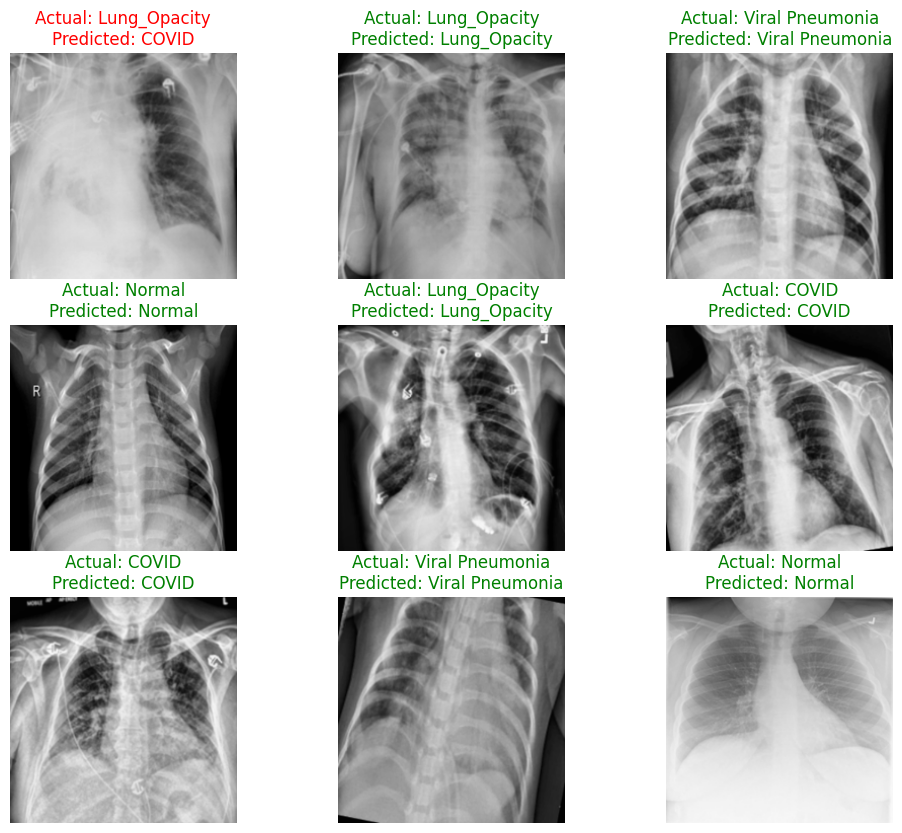

In [230]:
# Load best saved ResNet-50 model
resnet_model = load_model("initial_resnet50_model.keras")

# Prepare predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Reload test dataset temporarily to get class names
base_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"

temp_test_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "test"),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)
class_names = temp_test_ds.class_names

# Convert test_ds to list for indexing
image_batches = list(test_ds.as_numpy_iterator())
all_images = []
for batch in image_batches:
    images, _ = batch
    all_images.extend(images)

# Sample 9 random indices
sample_indices = random.sample(range(len(all_images)), 9)

# Plot predictions
plt.figure(figsize=(12, 10))

for i, idx in enumerate(sample_indices):
    img = all_images[idx]  # <-- FIXED HERE
    img_display = (img * 255).astype("uint8")  # convert from 0–1 to 0–255
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_display, cmap="gray")
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=color)
    plt.axis("off")



# **Hyper-Tuning Rest-Net Model**

In [231]:
#  Custom Focal Loss (No external dependency)
@tf.keras.utils.register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_sum(loss, axis=1)

# ✅ Load Pretrained ResNet-50 Base
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# ✅ Freeze all except last 40 layers for fine-tuning
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

# 🔧 Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

# 🔨 Build the model
resnet_model = Model(inputs=base_model.input, outputs=output)

# 🧠 Compile model using custom focal loss
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# ✅ Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_resnet50_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

# ✅ Training parameters
epochs = 30
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds)

# 🚀 Train the model
tune_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12752']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 132ms/step - accuracy: 0.5742 - loss: 0.1235 - val_accuracy: 0.4654 - val_loss: 0.2011 - learning_rate: 1.0000e-05
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.7934 - loss: 0.0527 - val_accuracy: 0.6912 - val_loss: 0.0941 - learning_rate: 1.0000e-05
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.8309 - loss: 0.0408 - val_accuracy: 0.7977 - val_loss: 0.0528 - learning_rate: 1.0000e-05
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8436 - loss: 0.0366 - val_accuracy: 0.6402 - val_loss: 0.1138 - learning_rate: 1.0000e-05
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.8645 - loss: 0.0319 - val_accuracy: 0.8694 - val_loss: 0.0306 - learning_rate: 1.0000e-05
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8799 - loss: 0.0272 - val_accuracy: 0.6858 - val_loss: 0.1187 - learning_rate: 1.0000e-05
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accurac

**Loss/Accuracy Plot**

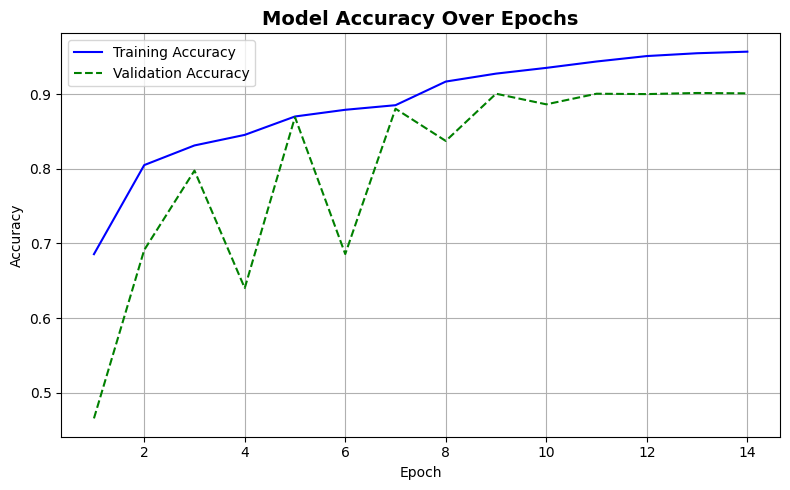

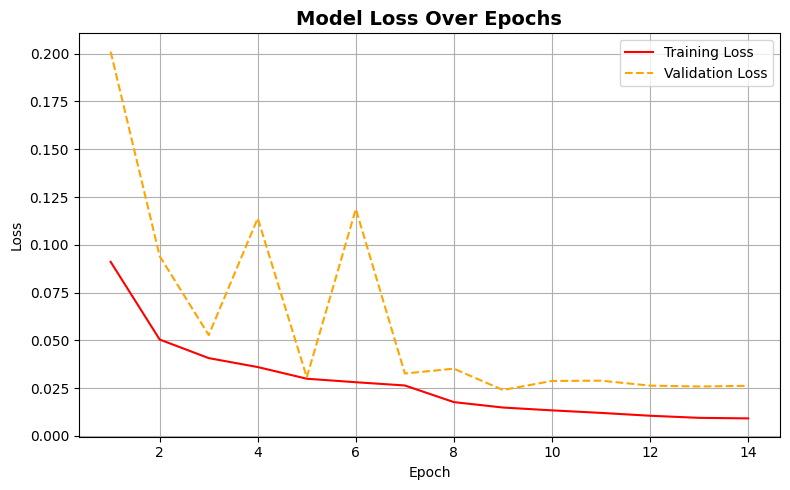

In [232]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # 📈 Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_plot.png", dpi=300)
    plt.show()

    # 📉 Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', linestyle='--', label='Validation Loss')
    plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png", dpi=300)
    plt.show()

# ✅ Call the function
plot_training_curves(tune_history)


**Classification Report**

                 precision    recall  f1-score   support

          COVID       0.84      0.78      0.81       250
   Lung_Opacity       0.80      0.85      0.82       250
         Normal       0.96      0.98      0.97       270
Viral Pneumonia       0.98      0.97      0.98       250

       accuracy                           0.90      1020
      macro avg       0.90      0.90      0.90      1020
   weighted avg       0.90      0.90      0.90      1020



<ipython-input-233-fdb623131d32>:37: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-233-fdb623131d32>:38: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig("resnet_classification_report.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


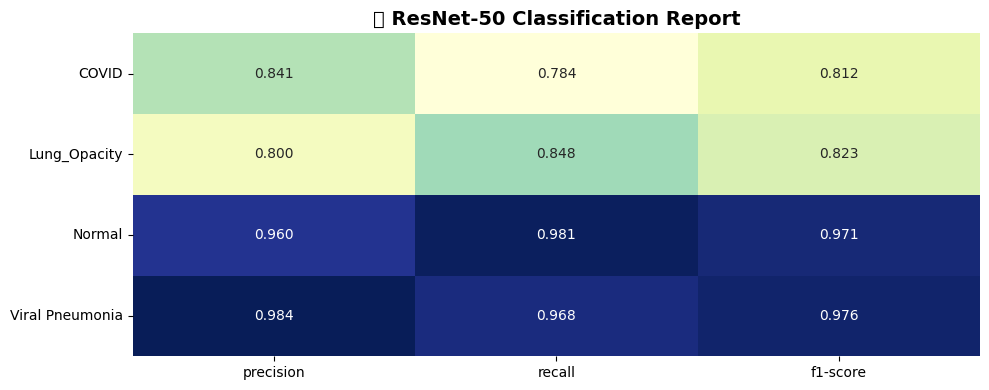

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Use the same model used for evaluation
model = load_model("best_resnet50_model.keras", custom_objects={"focal_loss_fixed": focal_loss_fixed})

# ✅ Ensure dataset has no shuffling or batching
test_ds_unbatched = test_ds.unbatch()
y_true = []
y_pred = []

for img, label in test_ds_unbatched:
    y_true.append(np.argmax(label.numpy()))
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    y_pred.append(np.argmax(pred))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Use consistent class names
class_names = temp_test_ds.class_names

# ✅ Classification report (Text)
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Classification report (Heatmap)
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

plt.figure(figsize=(10, 4))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title("📋 ResNet-50 Classification Report", fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("resnet_classification_report.png", dpi=300)
plt.show()


**Confusion Matrix**

<ipython-input-235-71e6f10f46b8>:10: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-235-71e6f10f46b8>:11: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig("resnet_confusion_matrix.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


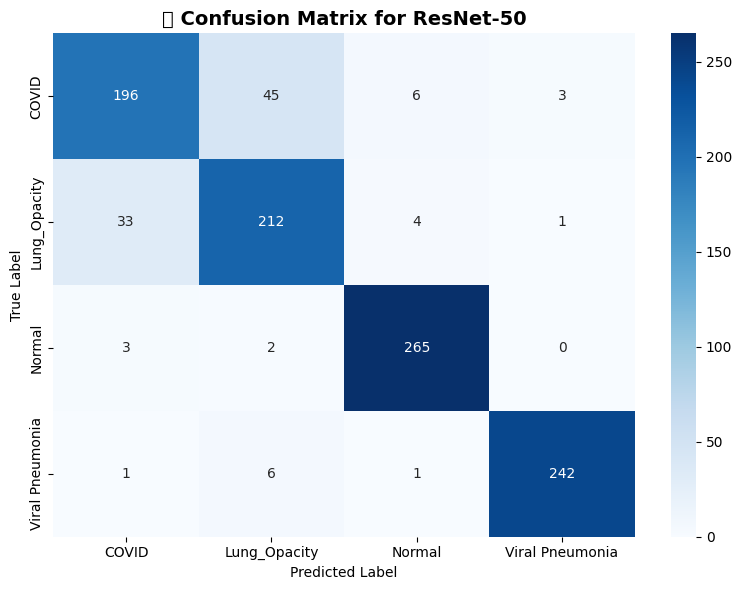

In [235]:
# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("🧩 Confusion Matrix for ResNet-50", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("resnet_confusion_matrix.png", dpi=300)
plt.show()

**Visualisizing the Test Predictions**

Found 1020 files belonging to 4 classes.


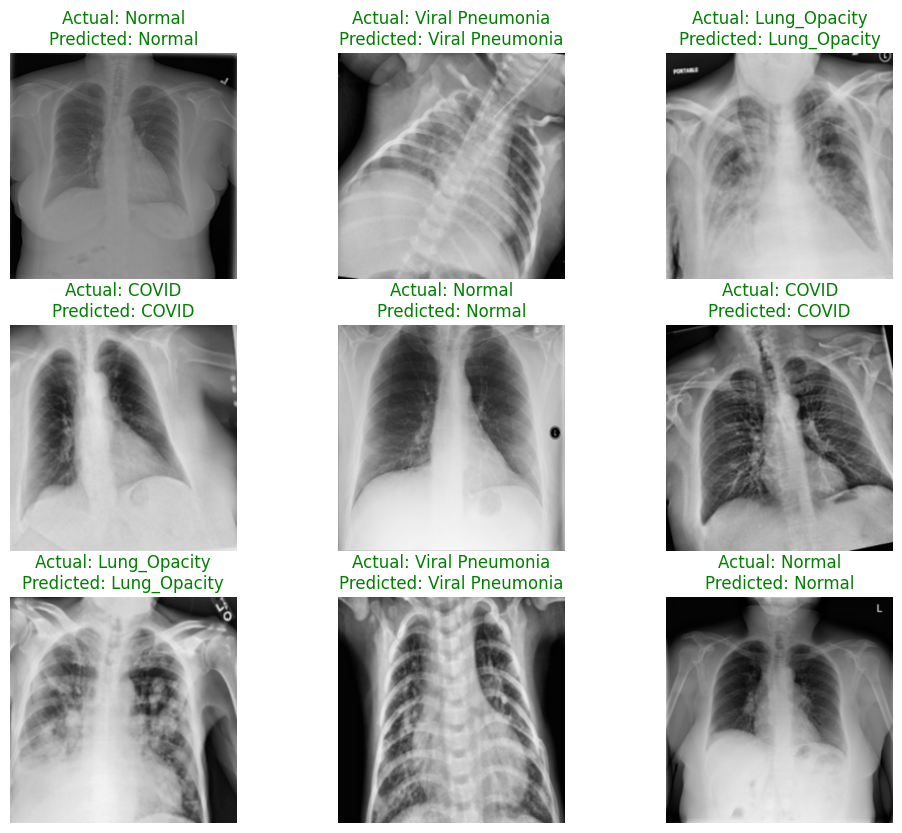

In [236]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"

temp_test_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "test"),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)
class_names = temp_test_ds.class_names

# Convert test_ds to list for indexing
image_batches = list(test_ds.as_numpy_iterator())
all_images = []
for batch in image_batches:
    images, _ = batch
    all_images.extend(images)

# Sample 9 random indices
sample_indices = random.sample(range(len(all_images)), 9)

# Plot predictions
plt.figure(figsize=(12, 10))

for i, idx in enumerate(sample_indices):
    img = all_images[idx]  # <-- FIXED HERE
    img_display = (img * 255).astype("uint8")  # convert from 0–1 to 0–255
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_display, cmap="gray")
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=color)
    plt.axis("off")

# Save Model For Predictions

In [172]:
model.save("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.keras")
files.download("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.keras")

'ADS2 - Tutorial 2 - PySpark Basics.ipynb'
 AmazonBooks.csv
 Aoun_PySpark_Assignment_Feb25.ipynb
 Augmented
 best_resnet50_model.h5
 best_resnet50_model.keras
'Bhavaya-ML Assignment'
'Copy of Pneumonia-Detection (1).ipynb'
'Copy of Pneumonia-Detection.ipynb'
 COVID-19_Radiography_Dataset
'E commerce'
 Final_Dataset
 games-data.csv
 Hackathon_dataset_4.ipynb
 Hackathon.ipynb
 intel_image_classification
'Keras_Assignment_Dec2024 (1).ipynb'
'Keras_Assignment_Dec2024 (2).ipynb'
'Keras_Assignment_Dec2024 (3).ipynb'
 Keras_Assignment_Dec2024.ipynb
'Keras_Assignment_Dec2024 -Tahreem.ipynb'
'Machine Learning Tutorial.ipynb'
'ML Assignment.ipynb'
'Multi-Class Diseases BE Development'
'Multi-Class Diseases Detection.ipynb'
 Pneumonia_Detection.ipynb
'PySpark_Assignment_Feb25 (1).ipynb'
'PySpark_Assignment_Feb25 (2).ipynb'
 PySpark_Assignment_Feb25.ipynb
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633) (1).ipynb'
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633).ipynb'
'PySpark_Assignment_Sep2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>